# Football Position predictions project

### Team - Gracia
#### Team members:
1. Oliver Gatland 
2. Arianna Michelangelo
3. Pere Pericot
4. Edward Monbiot

# Table of Contents

1. Data Preprocessing and Quality Assurance
2. Exploratory Data Analysis (EDA)
3. Feature Creation and Engineering
4. Model Selection and Performance Evaluation
5. Cross Validation (Model Justification)
6. Ensemble Modelling
7. Kaggle CSV Submission


# 1.Data Preprocessing and Quality Assurance

Import Packages

In [1]:
#download the packages to use
import pandas as pd
import warnings
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import lightgbm as lgb
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, LeaveOneOut, train_test_split
import time
from sklearn.model_selection import GridSearchCV
warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv('train.csv')  #load the trainings and test data
test = pd.read_csv('test.csv')

In [3]:
train.shape #identify the size of the train dataset

(6895, 70)

Missing Values Identification-Train

In [4]:
# Identify features with missing values
features_with_missing_values = train.columns[train.isnull().any()].tolist()

# Display the count of missing values for each feature
missing_values_count = train[features_with_missing_values].isnull().sum()

# Print the results
print("Features with missing values:")
print(features_with_missing_values)

print("\nCount of missing values for each feature:")
print(missing_values_count)

Features with missing values:
['value_eur', 'club_loaned_from', 'club_joined', 'nation_jersey_number', 'release_clause_eur', 'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'goalkeeping_speed']

Count of missing values for each feature:
value_eur                  2
club_loaned_from        6544
club_joined              351
nation_jersey_number    6482
release_clause_eur       353
player_tags             6124
player_traits           2589
pace                     631
shooting                 631
passing                  631
dribbling                631
defending                631
physic                   631
goalkeeping_speed       6264
dtype: int64


Missing Values Identification-Test

In [5]:
test.shape #identify the size of the test dataset, check how different it is against the train dataset  

(767, 69)

In [6]:
# Identify features with missing values
features_with_missing_values = test.columns[test.isnull().any()].tolist()

# Display the count of missing values for each feature
missing_values_count = test[features_with_missing_values].isnull().sum()

# Print the results
print("Features with missing values:")
print(features_with_missing_values)

print("\nCount of missing values for each feature:")
print(missing_values_count)

Features with missing values:
['value_eur', 'club_loaned_from', 'club_joined', 'nation_jersey_number', 'release_clause_eur', 'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'goalkeeping_speed']

Count of missing values for each feature:
value_eur                 3
club_loaned_from        722
club_joined              45
nation_jersey_number    716
release_clause_eur       48
player_tags             682
player_traits           285
pace                     70
shooting                 70
passing                  70
dribbling                70
defending                70
physic                   70
goalkeeping_speed       697
dtype: int64


Merge Test & Train Datasets

In [7]:
#create new columns is_test & is_train to distinguish test and train data after merge
test['is_train']=0 
train['is_train']=1


In [8]:
# concatenate train & test datasets to efficiently clean the data
all_data = pd.concat([train,test]).reset_index()

In [9]:
#display all columns
pd.set_option('display.max_columns', None) 

In [10]:
#check content of the dataset
all_data.head()

,index,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,league_name,league_level,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_name,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position,is_train
0,0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,Mexican Liga MX,1,29,NaN,2021-07-12,2026,Mexico,NaN,Right,5,3,1,Medium/High,Normal (170-185),No,2400000.0,NaN,Early Crosser,70.0,52.0,60.0,70.0,67.0,66.0,64,40,56,65,41,68,64,58,58,68,71,70,87,61,86,67,77,86,58,66,56,79,53,48,58,66,65,66,65,14,11,12,12,12,NaN,LB,1
1,1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,Scottish Premiership,1,4,NaN,2021-07-23,2022,Austria,NaN,Right,3,2,1,Medium/Medium,Lean (170-185),No,2000000.0,NaN,NaN,65.0,38.0,58.0,60.0,63.0,67.0,50,31,59,64,31,57,36,41,64,65,64,65,57,62,67,49,62,71,66,42,66,66,48,62,46,59,65,61,58,10,13,7,6,11,NaN,LDM,1
2,2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,Danish Superliga,1,19,NaN,2021-07-24,2026,Sweden,NaN,Left,3,3,1,High/Medium,Normal (170-185),No,2300000.0,NaN,Speed Dribbler (AI),79.0,35.0,58.0,66.0,59.0,64.0,59,30,53,60,37,65,56,35,55,64,82,77,71,62,75,50,65,67,61,28,69,62,58,60,31,65,60,58,59,10,10,8,10,11,NaN,LWB,1
3,3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,Korean K League 1,1,9,NaN,2018-02-08,2023,Montenegro,NaN,Right,3,3,1,High/Medium,Lean (185+),No,2900000.0,NaN,Finesse Shot,64.0,74.0,51.0,68.0,24.0,76.0,32,78,75,59,70,65,48,53,45,74,61,66,64,67,53,71,71,75,87,69,52,18,76,60,75,75,16,22,19,16,15,13,8,9,NaN,LS,1
4,4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,Romanian Liga I,1,30,NaN,2019-07-01,2022,Romania,NaN,Left,2,2,1,Medium/High,Normal (170-185),No,709000.0,NaN,Solid Player,74.0,53.0,59.0,53.0,61.0,69.0,64,38,49,63,46,43,53,58,55,56,71,76,70,60,71,72,80,78,70,67,53,63,60,52,52,58,64,61,58,12,5,11,12,15,NaN,LB,1


In [11]:
#check the size of the combined dataset
all_data.shape

(7662, 72)

In [12]:
#check the null values in the combined dataset
all_data.isna().sum()

index                         0
id                            0
short_name                    0
overall                       0
potential                     0
                           ... 
goalkeeping_positioning       0
goalkeeping_reflexes          0
goalkeeping_speed          6961
position                    767
is_train                      0
Length: 72, dtype: int64

In [13]:
# check the statistics of the dataset
all_data.describe()

,index,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,nation_jersey_number,weak_foot,skill_moves,international_reputation,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,is_train
count,7662.000000,7662.000000,7662.000000,7662.000000,7.657000e+03,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,464.000000,7662.000000,7662.000000,7662.000000,7.261000e+03,6961.000000,6961.000000,6961.000000,6961.000000,6961.000000,6961.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,701.000000,7662.000000
mean,3140.280084,223616.285435,68.842600,72.048029,4.331453e+06,12030.253198,181.484338,75.552467,1.361655,16.525320,2022.763508,12.056034,2.996346,2.451188,1.147481,8.187938e+06,68.568596,54.301250,60.085045,64.577791,55.609395,68.346215,52.883973,48.222527,55.069956,62.348865,44.775516,58.376273,50.381754,45.283738,56.815583,61.784652,65.905116,66.038110,65.287001,65.020752,64.850692,60.519838,67.255416,67.909554,68.229313,49.838684,59.815714,51.504960,53.130645,56.939441,49.895589,61.901592,51.349517,52.304098,49.800052,15.903289,15.672409,15.545680,15.813234,16.011877,40.375178,0.899896
std,2101.513688,26710.529813,5.951663,6.074939,1.045019e+07,24385.866372,6.860952,7.042419,0.761018,15.487419,1.207030,6.902991,0.685301,0.780693,0.470143,2.044656e+07,11.708722,14.354508,9.574193,9.348321,15.624753,8.509289,17.850296,19.569581,16.905886,13.281468,17.879807,17.897941,18.364759,17.835926,14.149990,15.398347,14.501858,14.401695,14.472439,7.930761,14.235664,13.076355,12.171742,15.096912,11.786433,19.300841,16.272640,20.123523,19.313219,13.559154,15.668827,10.886174,19.658360,20.918691,20.638862,17.466642,16.767293,16.319634,17.191808,17.877237,10.194699,0.300159
min,0.000000,41.000000,48.000000,53.000000,2.500000e+04,500.000000,156.000000,53.000000,1.000000,1.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,3.900000e+04,28.000000,18.000000,25.000000,29.000000,16.000000,31.000000,7.000000,2.000000,5.000000,7.000000,4.000000,4.000000,7.000000,6.000000,9.000000,10.000000,15.000000,15.000000,19.000000,32.000000,19.000000,20.000000,27.000000,14.000000,25.000000,4.000000,11.000000,6.000000,2.000000,10.000000,8.000000,12.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000,0.000000
25%,1148.250000,207642.250000,65.000000,68.000000,7.250000e+05,2000.000000,177.000000,70.000000,1.000000,6.000000,2022.000000,6.000000,3.000000,2.000000,1.000000,1.100000e+06,62.000000,43.000000,54.000000,59.000000,43.000000,63.000000,42.000000,33.000000,48.000000,58.000000,31.000000,53.000000,37.000000,32.000000,50.000000,58.000000,58.000000,59.000000,57.000000,60.000000,56.000000,51.000000,60.000000,63.000000,61.000000,35.000000,51.000000,33.000000,42.000000,48.000000,40.000000,56.000000,35.000000,34.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000,33.000000,1.000000
5

In [14]:
#check the data types of the combined dataset
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        7662 non-null   int64  
 1   id                           7662 non-null   int64  
 2   short_name                   7662 non-null   object 
 3   overall                      7662 non-null   int64  
 4   potential                    7662 non-null   int64  
 5   value_eur                    7657 non-null   float64
 6   wage_eur                     7662 non-null   int64  
 7   birthday_date                7662 non-null   object 
 8   height_cm                    7662 non-null   int64  
 9   weight_kg                    7662 non-null   int64  
 10  club_name                    7662 non-null   object 
 11  league_name                  7662 non-null   object 
 12  league_level                 7662 non-null   int64  
 13  club_jersey_number

# 2. Exploratory Data Analysis (EDA)

Characteristics Per Position 

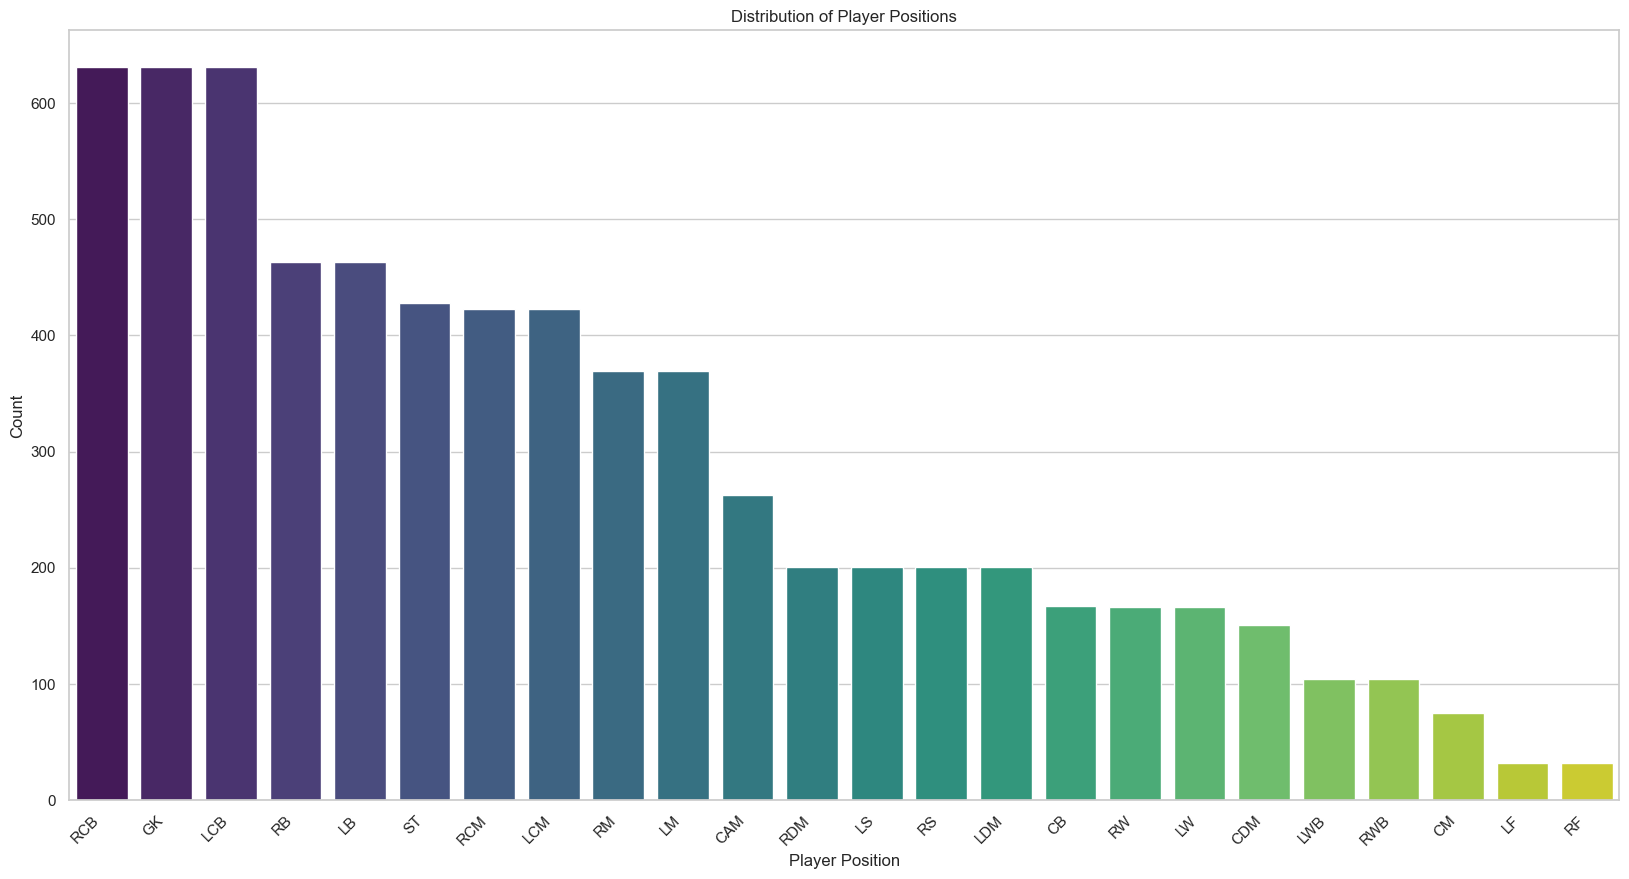

In [15]:
#understand how the target variable position is distributed
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))

# Plot the distribution of player positions
position_distribution = sns.countplot(x='position', data=all_data, order=all_data['position'].value_counts().index, palette='viridis') 

position_distribution.set(xlabel='Player Position', ylabel='Count', title='Distribution of Player Positions')

# Rotate x-axis labels for better visibility
position_distribution.set_xticklabels(position_distribution.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()


Most players play in the RCB, GK and LCB positions. LF and RF have the smallest amount of footballers playing in these postions

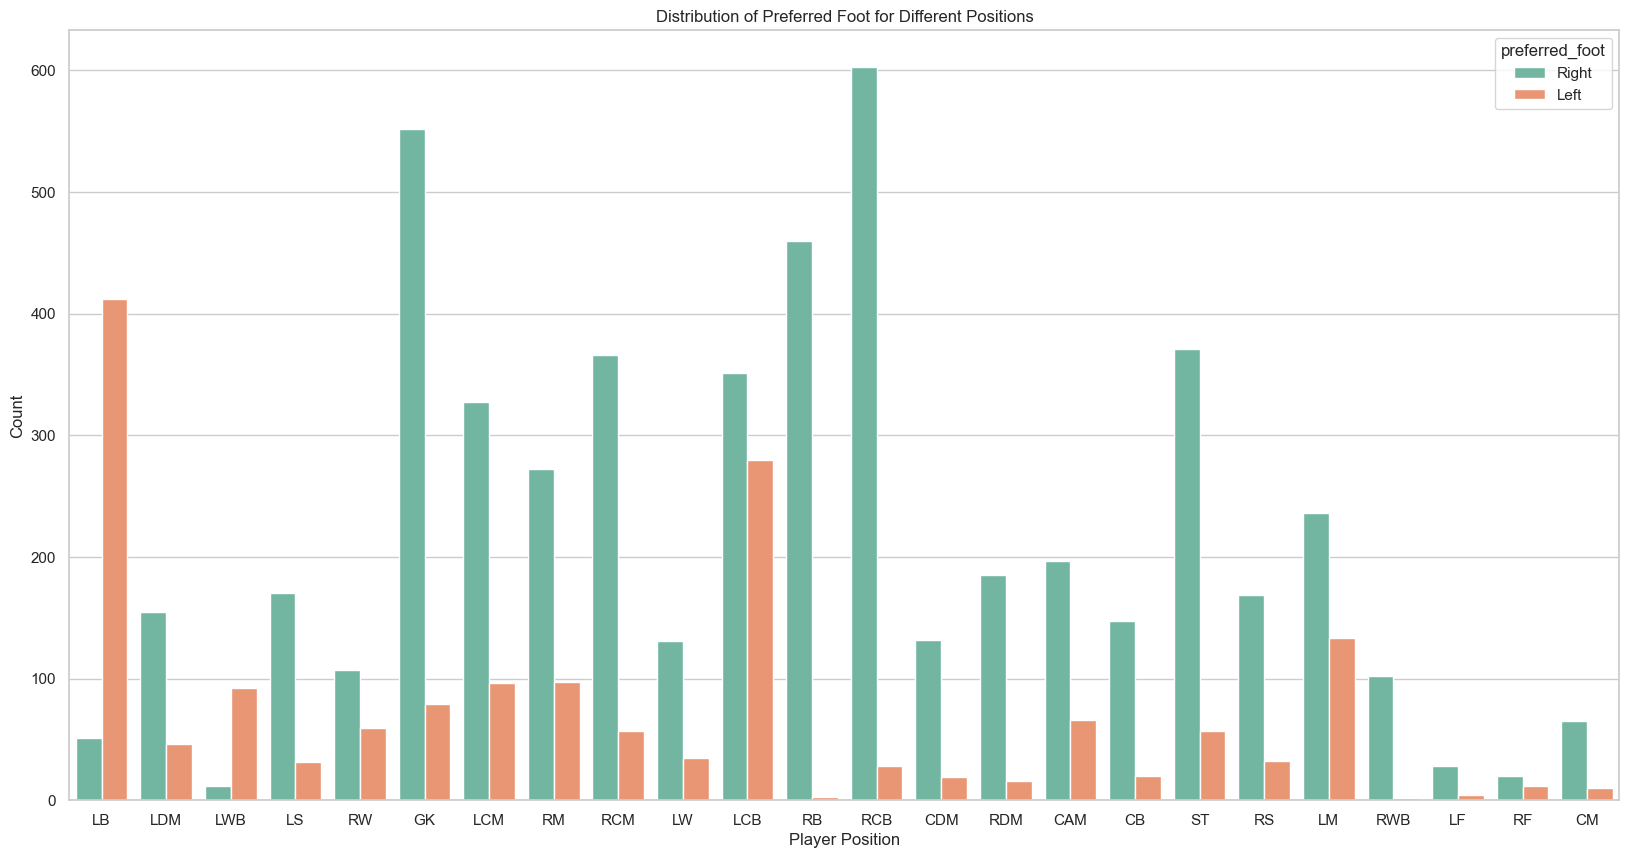

In [16]:
# plot preferred foot by position
plt.figure(figsize=(20,10))
sns.countplot(x='position', hue ='preferred_foot', data=all_data, palette='Set2')
plt.title('Distribution of Preferred Foot for Different Positions')
plt.xlabel('Player Position')
plt.ylabel('Count')
plt.show()

Most footballers are right footed. As expected right footed players dominate the RB position and left footed players dominate the LB positions.

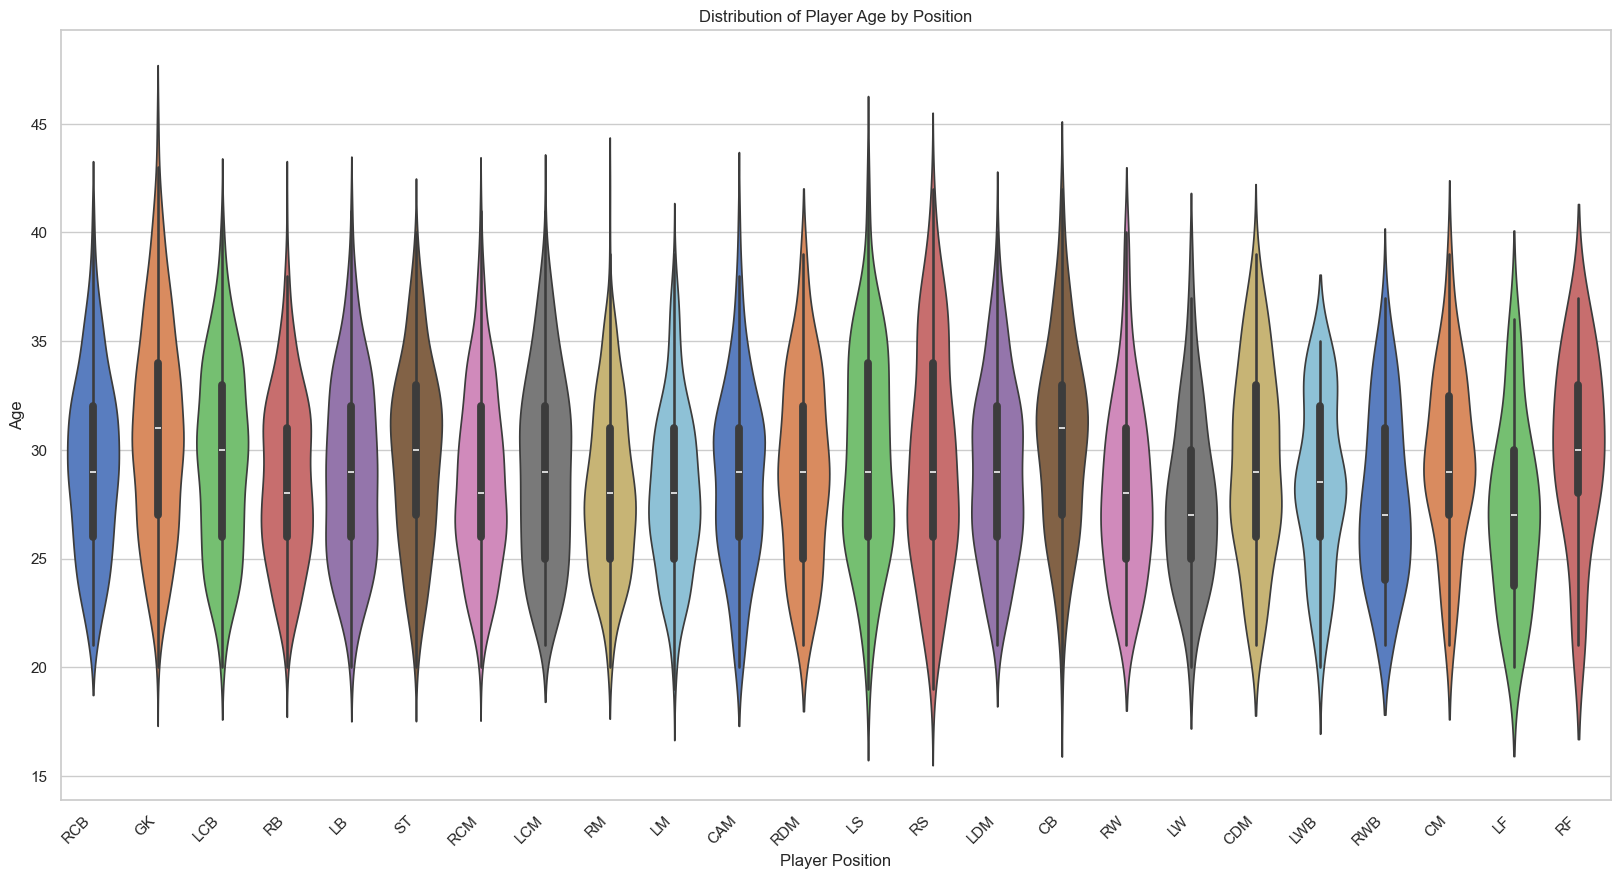

In [17]:
#plot player age by position
all_data['birthday_date'] = pd.to_datetime(all_data['birthday_date'])
all_data['age'] = np.floor_divide((pd.to_datetime('today') - all_data['birthday_date']).dt.days, 365.25)

plt.figure(figsize=(20,10))
age_distribution = sns.violinplot(x='position', y='age', data=all_data, order=all_data['position'].value_counts().index, palette='muted')

age_distribution.set(xlabel='Player Position', ylabel='Age', title='Distribution of Player Age by Position')

age_distribution.set_xticklabels(age_distribution.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()


GK have typically have the longest careers with some playing until 45+ LS and RS have the youngest players with some players only 16 years old

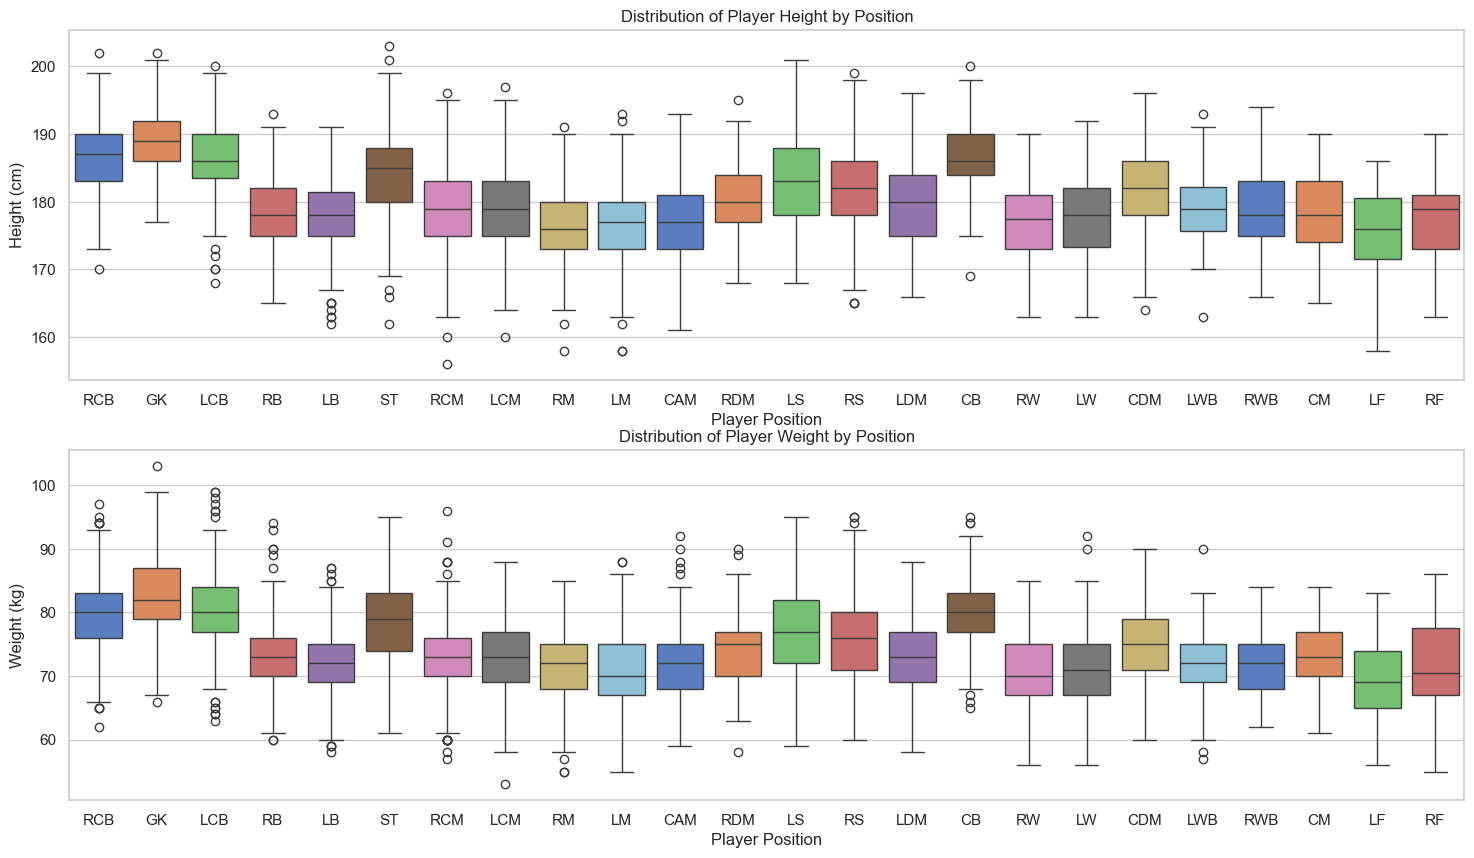

In [18]:
# plot to understand the optimum physical characteristics by position

plt.figure(figsize=(18,10))

# height analysis
plt.subplot(2,1,1)
height_distribution = sns.boxplot(x='position', y='height_cm', data=all_data, order=all_data['position'].value_counts().index, palette='muted')
height_distribution.set(xlabel='Player Position', ylabel='Height (cm)', title='Distribution of Player Height by Position')

# weight analysis
plt.subplot(2,1,2)
weight_distribution = sns.boxplot(x='position', y='weight_kg', data=all_data, order=all_data['position'].value_counts().index, palette='muted')
weight_distribution.set(xlabel='Player Position', ylabel='Weight (kg)', title='Distribution of Player Weight by Position')

plt.show()

GK have the highest average height, with ST containing the largest height distribution. Height is least important in the LF and RM positions. In term of weight GK followed by CB are the heaviest players and LF and RM are typically the lightest players

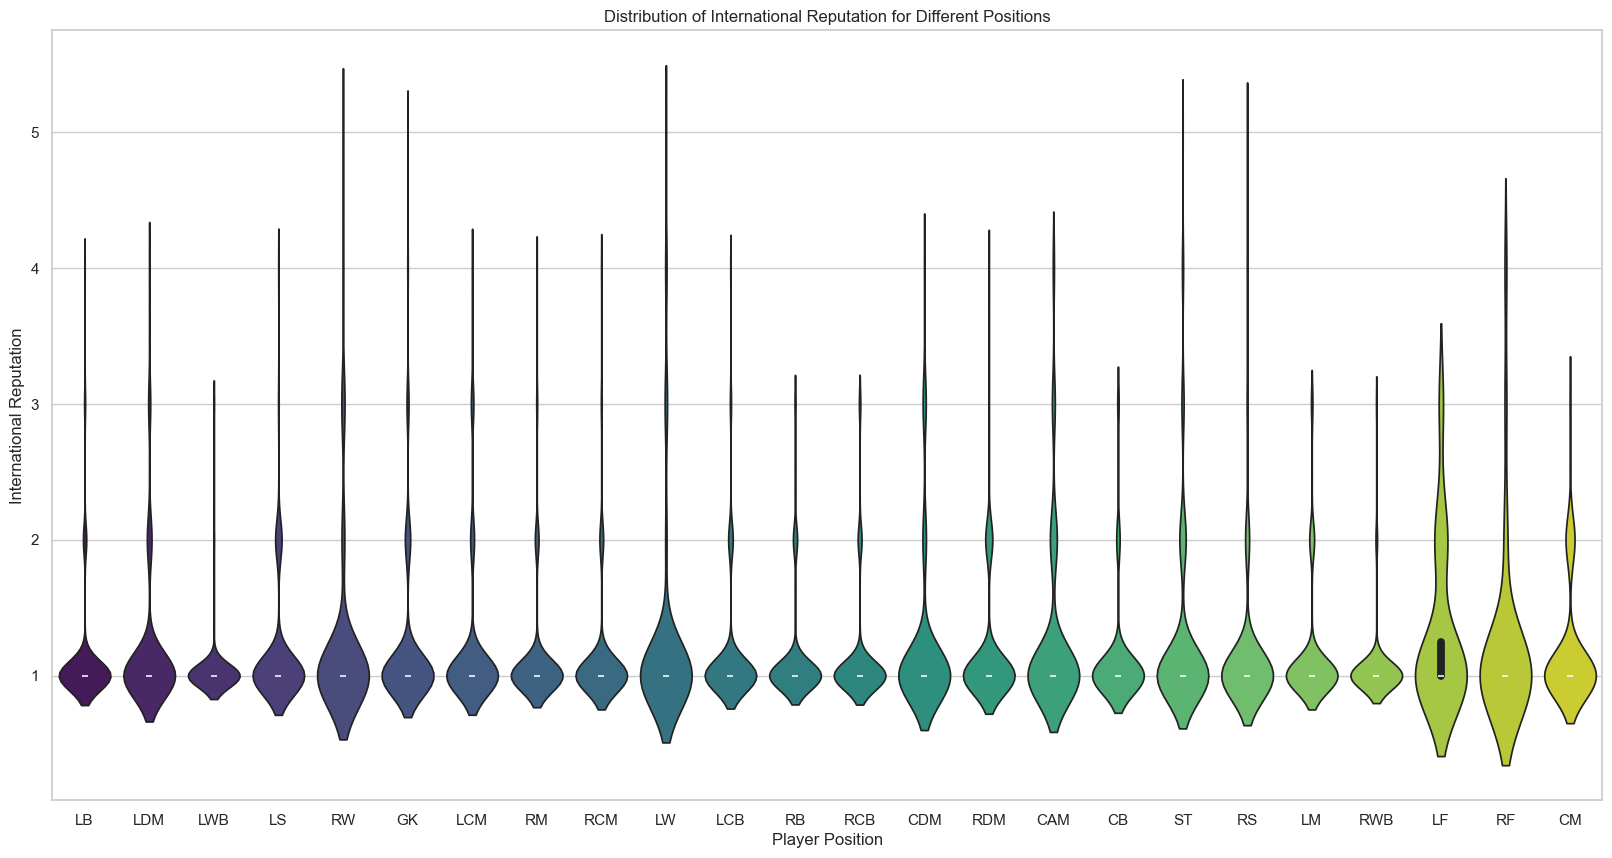

In [19]:
# check how international reputation trends per position
plt.figure(figsize=(20,10))
sns.violinplot(x='position', y='international_reputation', data=all_data, palette='viridis')
plt.title('Distribution of International Reputation for Different Positions')
plt.xlabel('Player Position')
plt.ylabel('International Reputation')
plt.show()

LW, RW have the highest count for international reputation, LWB, RB, RCB, CB, LM, RWB have the lowest count

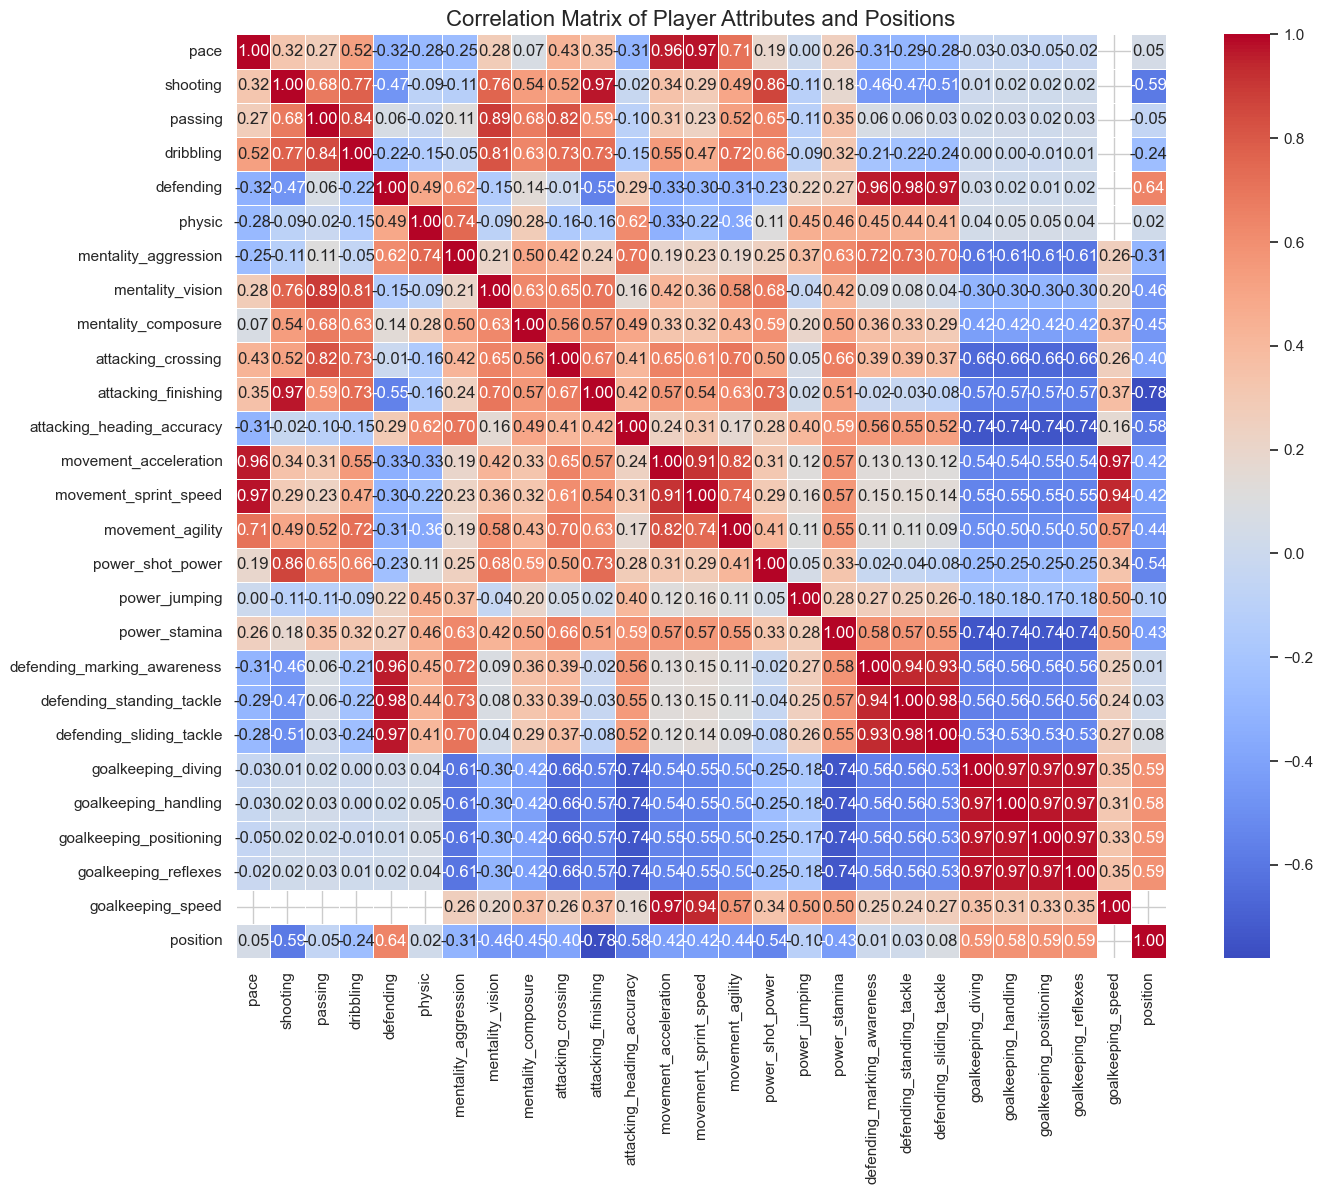

In [20]:
# check for correlation between attributes accross different position

# Select relevant columns for correlation analysis
attributes_for_correlation = [
    'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
    'mentality_aggression', 'mentality_vision', 'mentality_composure',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
    'power_shot_power', 'power_jumping', 'power_stamina',
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
    'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_positioning',
    'goalkeeping_reflexes', 'goalkeeping_speed'
]

# Add 'position' to the selected columns
attributes_for_correlation.append('position')

# Create a subset of the dataframe with selected columns
subset_df = all_data[attributes_for_correlation]

# Convert categorical position labels into numerical values for correlation analysis
position_mapping = {'ST': 0, 'CF': 1, 'RW': 2, 'LW': 3, 'CAM': 4, 'CM': 5, 'CDM': 6, 'RM': 7, 'LM': 8, 'CB': 9, 'RB': 10, 'LB': 11, 'RWB': 12, 'LWB': 13, 'GK': 14}
subset_df['position'] = subset_df['position'].map(position_mapping)

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Add a legend
heatmap.set_title('Correlation Matrix of Player Attributes and Positions', fontsize=16)
plt.show()

The goalkeeping attributes are highly correlated, so are pace vs movement and so are tackling and defending. It is evident that in each position there are highly correlated attributes.

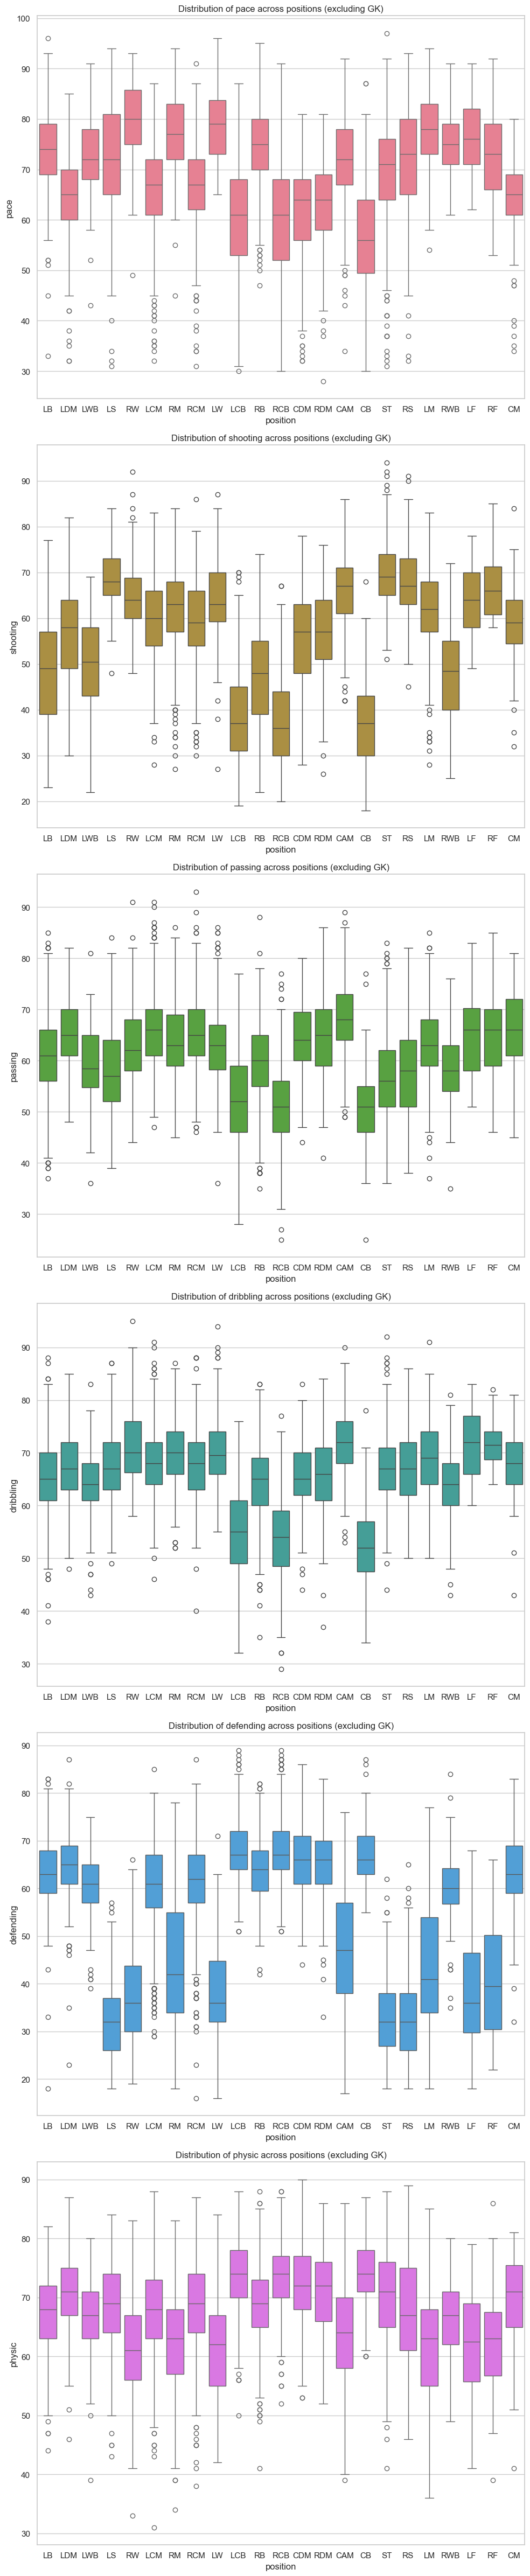

In [21]:
# now we want to check which skills are associated with each position

# List of skill attributes
skill_attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

# Exclude position 'GK' from the data as it is not relevant for the analysis
filtered_data = all_data[all_data['position'] != 'GK']

# Set up subplots
fig, axes = plt.subplots(nrows=len(skill_attributes), ncols=1, figsize=(10, 8 * len(skill_attributes)))

# Generate a list of distinct colors
colors = sns.color_palette("husl", n_colors=len(skill_attributes))

# Plotting loop with distinct colors
for i, (attribute, color) in enumerate(zip(skill_attributes, colors)):
    sns.boxplot(x='position', y=attribute, data=filtered_data, ax=axes[i], color=color)
    axes[i].set_title(f'Distribution of {attribute} across positions (excluding GK)')

# Adjust layout
plt.tight_layout()
plt.show()


Pace: RW and LW require the most pace whilst RCB, LCB & CB are require the least pace.

Shooting: Several of the attacking positions require strong shooting skills particularly ST & LS and not important for the defending positions (CB, LCB, RCB)

Passing: Most important trait for CAM and RDN and least important for LCB and RCB

Dribbling: RW and CAM need the strongest dribbling skills while it matters least for LCB and CB

Defending: As expected the defending positions (LCB, RB, RCB, RDM) require the highest skill, and the attacking positions require the least

Physic: this characteristic is more evenly distributed accross all poistions. But RDM and LCB have the highest average physical skill 

In [22]:
# Identify features with missing values
features_with_missing_values = all_data.columns[all_data.isnull().any()].tolist()

# Display the count of missing values for each feature
missing_values_count = all_data[features_with_missing_values].isnull().sum()

# Print the results
print("Features with missing values:")
print(features_with_missing_values)

print("\nCount of missing values for each feature:")
print(missing_values_count)

Features with missing values:
['value_eur', 'club_loaned_from', 'club_joined', 'nation_jersey_number', 'release_clause_eur', 'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'goalkeeping_speed', 'position']

Count of missing values for each feature:
value_eur                  5
club_loaned_from        7266
club_joined              396
nation_jersey_number    7198
release_clause_eur       401
player_tags             6806
player_traits           2874
pace                     701
shooting                 701
passing                  701
dribbling                701
defending                701
physic                   701
goalkeeping_speed       6961
position                 767
dtype: int64


After the EDA, we clean the dataset

In [23]:
# Dropping extra columns which don't add value
columns1 = ['short_name', 'club_name', 'league_name', 'nationality_name', 'real_face']
all_data = all_data.drop(columns1, axis=1)

In [24]:
# Drop variables with more than 80% of missing values

all_data = all_data.drop(["club_loaned_from", "nation_jersey_number", "player_tags", "goalkeeping_speed"], axis=1)

# 3. Feature Creation and Engineering

In [25]:
# Cleaning player_traits

# Function to convert the string list to a list
def clean_traits(x):
    if isinstance(x, str):
        return x.split(',')
    else:
        return x

# Apply function to column
all_data['player_traits'] = all_data['player_traits'].apply(clean_traits)

# Look at number of unique player traits
traits = [trait for sublist in all_data[~all_data['player_traits'].isna()]['player_traits'] for trait in sublist]

# Count the occurrences of each string
trait_counts = Counter(traits)

# Get the unique strings and their counts
print('The number of unique traits is ' + str(len(trait_counts.keys())))

The number of unique traits is 48


Significant number of unique traits, we need to investigate how it is distributed

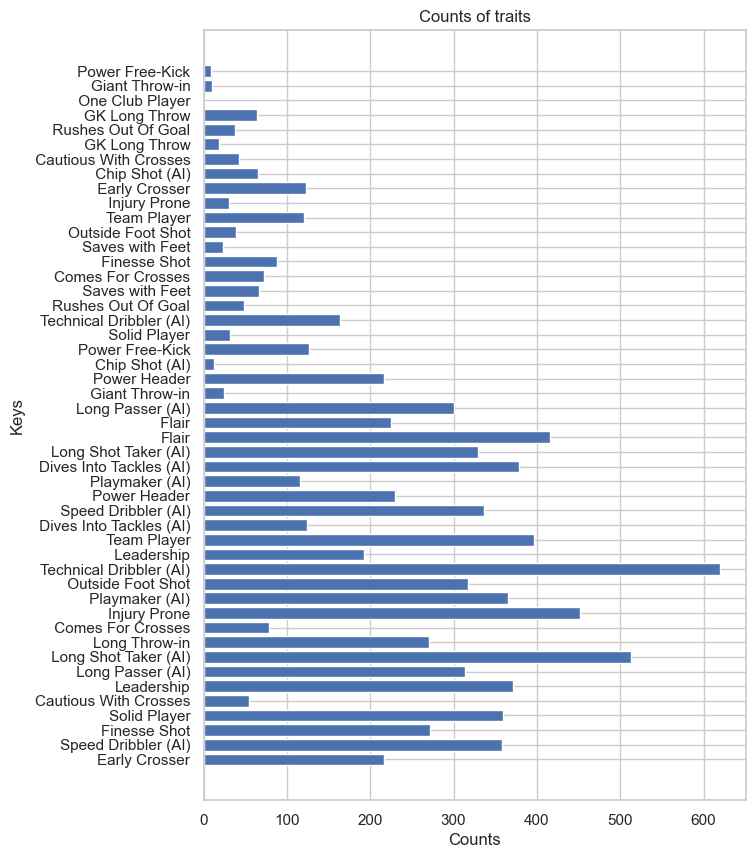

In [26]:
# Plot chart with traits
keys, counts = zip(*trait_counts.items())

fig, ax = plt.subplots(figsize=(7, 10))
ax.barh(keys, counts)
ax.set_xlabel('Counts')
ax.set_ylabel('Keys')
ax.set_title('Counts of traits')
plt.show()

Technical Drippler and Long Shot Taker are the most common traits.

In [27]:
# Feature generation with dates variable to get the number of years in club and age

# Convert 'birthdate' to a datetime object
all_data['club_joined'] = pd.to_datetime(all_data['club_joined'])
all_data['birthday_date'] = pd.to_datetime(all_data['birthday_date'])

# Define the reference date (e.g., the current date)
reference_date = datetime.now()

# Calculate the age by subtracting the birthdate from the reference date
all_data['yearinclub'] = (reference_date - all_data['club_joined']).dt.days // 365
all_data['age'] = (reference_date - all_data['birthday_date']).dt.days // 365

all_data['years_until_contract_expires'] =  all_data.club_contract_valid_until - datetime.today().year

# Print the result
print(all_data[['yearinclub', 'age', 'years_until_contract_expires']].head())


   yearinclub  age  years_until_contract_expires
0         2.0   33                             3
1         2.0   27                            -1
2         2.0   22                             3
3         5.0   31                             0
4         4.0   33                            -1


In [28]:
# Cleaning the body type variable
def extract_bodytype(bodytype_string):
    return bodytype_string.split()[0]

# Apply the function to the 'bodytype' column
all_data['body_type'] = all_data['body_type'].apply(extract_bodytype)

print(all_data['body_type'].unique())

['Normal' 'Lean' 'Stocky' 'Unique']


In [29]:
# Work_rate
print(all_data['work_rate'].unique())

['Medium/High' 'Medium/Medium' 'High/Medium' 'High/Low' 'High/High'
 'Medium/Low' 'Low/Medium' 'Low/High' 'Low/Low']


In [30]:
# Creating categorical variables for the work rate
all_data['attacking_wr'] = all_data['work_rate'].apply(lambda x: x.split('/')[0])
all_data['defensive_wr'] = all_data['work_rate'].apply(lambda x: x.split('/')[1])

def wr_converter(wr):
    if wr == 'High':
        return 3
    if wr == 'Medium':
        return 2
    if wr == 'Low':
        return 1
    
all_data['attacking_wr'] = all_data['attacking_wr'].apply(wr_converter)
all_data['defensive_wr'] = all_data['defensive_wr'].apply(wr_converter) 

In [31]:
encoder = LabelEncoder() #encode categorical variables for body type and preferred foot
all_data['body_type_encoded'] = encoder.fit_transform(all_data['body_type'])
all_data['preferred_foot_encoded'] = encoder.fit_transform(all_data['preferred_foot'])

In [32]:
# Identify features with missing values
features_with_missing_values = all_data.columns[all_data.isnull().any()].tolist()

# Display the count of missing values for each feature
missing_values_count = all_data[features_with_missing_values].isnull().sum()

# Print the results
print("Features with missing values:")
print(features_with_missing_values)

print("\nCount of missing values for each feature:")
print(missing_values_count)

Features with missing values:
['value_eur', 'club_joined', 'release_clause_eur', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'position', 'yearinclub']

Count of missing values for each feature:
value_eur                5
club_joined            396
release_clause_eur     401
player_traits         2874
pace                   701
shooting               701
passing                701
dribbling              701
defending              701
physic                 701
position               767
yearinclub             396
dtype: int64


In [33]:
# Display variables with more than 80% missing values
missing_percentages = all_data.isnull().sum() / len(all_data) * 100
threshold = 80
print(missing_percentages[missing_percentages > threshold])


Series([], dtype: float64)


In [34]:
#we use the KNNimputer to imputate the missing values in the numeric variables
def impute(data,columns):
    # Create KNNImputer object with k=8
    imputer = KNNImputer(n_neighbors=80)
    # Perform KNN imputation
    data[columns] = imputer.fit_transform(data[columns])
    return data[columns]

imputer_columns=['value_eur', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'yearinclub']

impute(all_data,imputer_columns)
all_data.isna().sum()

index                           0
id                              0
overall                         0
potential                       0
value_eur                       0
                               ..
years_until_contract_expires    0
attacking_wr                    0
defensive_wr                    0
body_type_encoded               0
preferred_foot_encoded          0
Length: 70, dtype: int64

All the missing values were filled using the KNN method

In [35]:
# Normalizing the numerical data (we do not normalize the jersey number)
def normalize_data(data):
    min_value = min(data)
    max_value = max(data)
    normalized_data = []

    for value in data:
        normalized_value = (value - min_value) / (max_value - min_value)
        normalized_data.append(normalized_value)

    return normalized_data

all_data['overall'] = normalize_data(all_data['overall'])
all_data['potential'] = normalize_data(all_data['potential'])
all_data['value_eur'] = normalize_data(all_data['value_eur'])
all_data['wage_eur'] = normalize_data(all_data['wage_eur'])
all_data['height_cm'] = normalize_data(all_data['height_cm'])
all_data['weight_kg'] = normalize_data(all_data['weight_kg'])
all_data['league_level'] = normalize_data(all_data['league_level'])
all_data['weak_foot'] = normalize_data(all_data['weak_foot'])
all_data['skill_moves'] = normalize_data(all_data['skill_moves'])
all_data['international_reputation'] = normalize_data(all_data['international_reputation'])
all_data['release_clause_eur'] = normalize_data(all_data['release_clause_eur'])
all_data['pace'] = normalize_data(all_data['pace'])
all_data['shooting'] = normalize_data(all_data['shooting'])
all_data['passing'] = normalize_data(all_data['passing'])
all_data['dribbling'] = normalize_data(all_data['dribbling'])
all_data['defending'] = normalize_data(all_data['defending'])
all_data['physic'] = normalize_data(all_data['physic'])
all_data['attacking_crossing'] = normalize_data(all_data['attacking_crossing'])
all_data['attacking_heading_accuracy'] = normalize_data(all_data['attacking_heading_accuracy'])
all_data['preferred_foot_encoded'] = normalize_data(all_data['preferred_foot_encoded'])
all_data['mentality_positioning'] = normalize_data(all_data['mentality_positioning'])
all_data['attacking_finishing'] = normalize_data(all_data['attacking_finishing'])
all_data['defending_sliding_tackle'] = normalize_data(all_data['defending_sliding_tackle'])
all_data['goalkeeping_reflexes'] = normalize_data(all_data['goalkeeping_reflexes'])
all_data['mentality_interceptions'] = normalize_data(all_data['mentality_interceptions'])
all_data['power_strength'] = normalize_data(all_data['power_strength'])

display(all_data)

,index,id,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,league_level,club_jersey_number,club_joined,club_contract_valid_until,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,release_clause_eur,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position,is_train,age,yearinclub,years_until_contract_expires,attacking_wr,defensive_wr,body_type_encoded,preferred_foot_encoded
0,0,216302,0.511111,0.428571,0.007089,0.027182,1989-12-28,0.425532,0.40,0.00,29,2021-07-12,2026,Right,1.00,0.50,0.0,Medium/High,Normal,0.006322,[Early Crosser],0.608696,0.447368,0.514706,0.621212,0.680000,0.593220,0.655172,0.408602,0.579545,65,41,68,64,58,58,68,71,70,87,61,86,67,77,86,0.471429,66,56,0.858824,0.542553,48,58,66,65,66,0.686047,14,11,12,12,0.113636,LB,1,33,2.0,3,2,3,1,1.0
1,1,237867,0.377778,0.428571,0.005026,0.004292,1996-10-23,0.574468,0.40,0.00,4,2021-07-23,2022,Right,0.50,0.25,0.0,Medium/Medium,Lean,0.005251,NaN,0.536232,0.263158,0.485294,0.469697,0.626667,0.610169,0.494253,0.311828,0.613636,64,31,57,36,41,64,65,64,65,57,62,67,49,62,71,0.585714,42,66,0.705882,0.489362,62,46,59,65,61,0.604651,10,13,7,6,0.102273,LDM,1,27,2.0,-1,2,2,0,1.0
2,2,253472,0.377778,0.571429,0.008120,0.004292,2001-09-27,0.468085,0.32,0.00,19,2021-07-24,2026,Left,0.50,0.50,0.0,High/Medium,Normal,0.006054,[Speed Dribbler (AI)],0.739130,0.223684,0.485294,0.560606,0.573333,0.559322,0.597701,0.301075,0.545455,60,37,65,56,35,55,64,82,77,71,62,75,50,65,67,0.514286,28,69,0.658824,0.595745,60,31,65,60,58,0.616279,10,10,8,10,0.102273,LWB,1,22,2.0,3,3,2,1,0.0
3,3,223994,0.533333,0.452381,0.011728,0.012876,1992-02-26,0.680851,0.56,0.00,9,2018-02-08,2023,Right,0.50,0.50,0.0,High/Medium,Lean,0.007661,[Finesse Shot],0.521739,0.736842,0.382353,0.590909,0.106667,0.762712,0.287356,0.817204,0.795455,59,70,65,48,53,45,74,61,66,64,67,53,71,71,75,0.885714,69,52,0.141176,0.787234,60,75,75,16,22,0.151163,16,15,13,8,0.079545,LS,1,31,5.0,0,3,2,0,1.0
4,4,251635,0.377778,0.285714,0.002578,0.007153,1990-06-12,0.489362,0.42,0.00,30,2019-07-01,2022,Left,0.25,0.25,0.0,Medium/High,Normal,0.001794,[Solid Player],0.666667,0.460526,0.500000,0.363636,0.600000,0.644068,0.655172,0.387097,0.500000,63,46,43,53,58,55,56,71,76,70,60,71,72,80,78,0.642857,67,53,0.670588,0.617021,52,52,58,64,61,0.604651,12,5,11,12,0.147727,LB,1,33,4.0,-1,2,3,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,762,205601,0.533333,0.452381,0.011728,0.047210,1992-01-10,0.191489,0.24,0.00,3,2021-07-17,2025,Left,0.50,0.50,0.0,Medium/Low,Lean,0.010071,[Speed Dribbler (AI)],0.782609,0.631579,0.632353,0.696970,0.240000,0.152542,0.701149,0.655914,0.477273,70,58,76,70,58,61,72,86,78,86,65,87,72,65,50,0.085714,66,43,0.341176,0.755319,71,70,64,30,33,0.302326,13,12,12,10,0.079545,NaN,0,31,2.0,2,2,1,0,0.0
7658,763,223752,0.444444,0.500000,0.008635,0.004292,1996-04-17,0.510638,0.34,0.00,2,2019-01-01,2022,Right,0.25,0.25,0.0,Low/High,Stocky,0.006857,NaN,0.579710,0.342105,0.367647,0.303030,0.653333,0.847458,0.517241,0.397849,0.750000,59,46,34,35,29,53,60,66,69,65,63,57,52,91,78,0.8

Data successfully normalised 

# 4. Model Selection and Performance Evaluation

In [36]:
# Deconcatenate the test data and train data from the all_data
train_data = all_data.loc[all_data.is_train == 1]
test_data = all_data.loc[all_data.is_train == 0]

In [37]:
# Check deconcatenation was executed properly and that we are working with correct dataframes
train_data.shape,test_data.shape

((6895, 70), (767, 70))

In [38]:
# Subset data into test and train, using only the features which are likely to be useful for predicting position
columns_for_prediction = ['overall', 'potential', 'value_eur', 'wage_eur','height_cm', 'weight_kg', 'club_jersey_number', 'weak_foot', 'skill_moves', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'age', 'body_type_encoded', 'attacking_wr', 'defensive_wr', 'preferred_foot_encoded']
X = train_data[columns_for_prediction] # Features
y = train_data['position']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

We start by running a logistic regression model, a random forest model, and a Light GBM classifier

In [39]:
# Logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# PRedict on test set
log_reg_predictions = log_reg.predict(X_test)

# Evaluate logistic regression model
log_reg_f1 = f1_score(y_test, log_reg_predictions, average="weighted")
print("Logistic Regression F1:", log_reg_f1)

Logistic Regression F1: 0.39757487474397624


In [40]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the Random Forest model
rf_f1 = f1_score(y_test, rf_predictions, average="weighted")
print("Random Forest F1:", rf_f1)

Random Forest F1: 0.3919530998588019


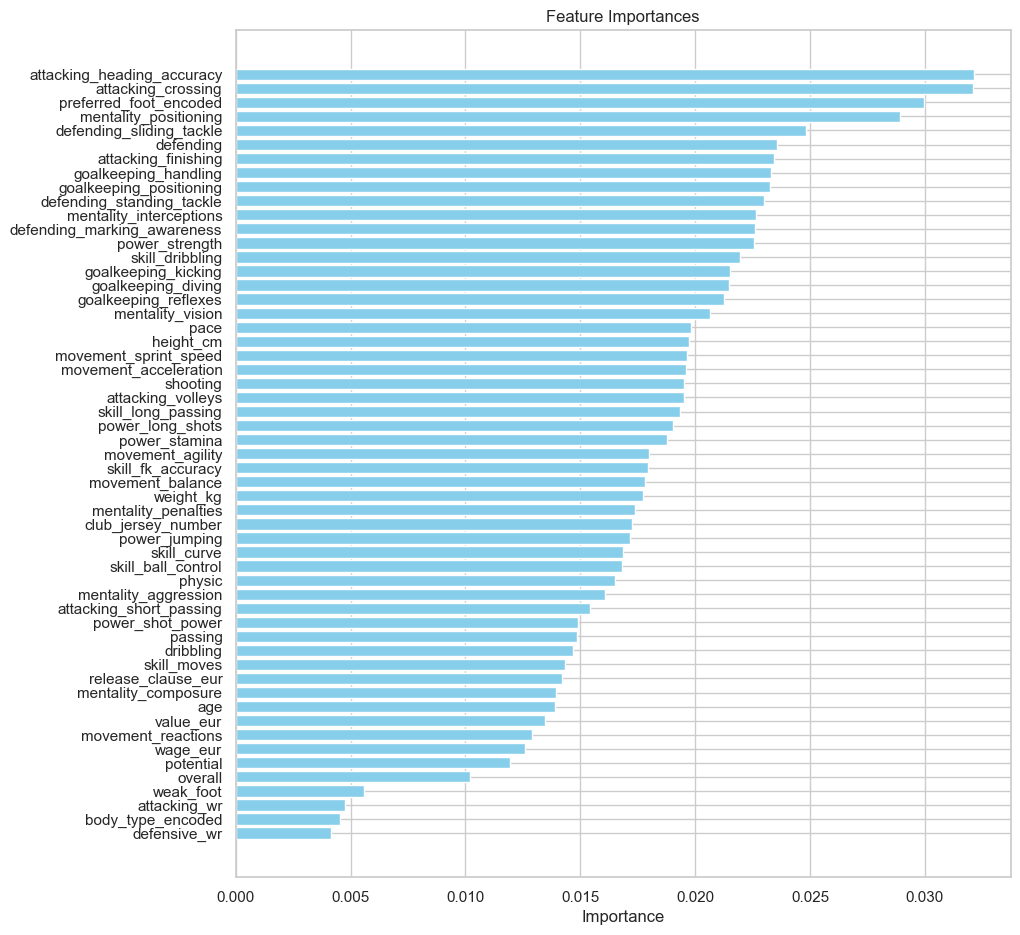

In [41]:
# Feature importance for rf classifier
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 11))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

The above graph shows how influencial the different features are within the random forest model. We can see that some of the most important features for position prediction are "attacking heading accuracy", "attacking crossing", and "preferred foot encoded".

In [42]:
#Lightgbm estimator
lightgbm = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lightgbm.fit(X_train, y_train)
light_predictions = lightgbm.predict(X_test)
# Evaluate the Loghtgbm model
light_f1 = f1_score(y_test, light_predictions, average="weighted")
print("LightGBM F1:", light_f1)

LightGBM F1: 0.37891046093889313


# 5. Cross Validation (Model Justification)

We now implement cross validation. We cross validate using both the standard 5 K-fold approach, and the stratified K-fold approach to compare the outcomes.

In [43]:
# Function to implement cross-validation and measure time
def evaluate_model_with_time(model, X, y, cv):
    start_time = time.time()
    scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return scores.mean(), elapsed_time

# Create a dictionary to store the results and time spent
results_linear = {}
results_rf = {}
times_linear = {}
times_rf = {}
results_light = {}
times_light = {}

In [44]:
# Method 1: Default cross-validation, standard 5 k-fold
kf = KFold(n_splits=5)
results_linear['K-fold'], times_linear['K-fold'] = evaluate_model_with_time(log_reg, X, y, cv=kf)
results_rf['K-fold'], times_rf['K-fold'] = evaluate_model_with_time(rf_model, X, y, cv=kf)
results_light['K-fold'], times_light['K-fold'] = evaluate_model_with_time(lightgbm, X, y, cv=kf)

In [45]:
# Method 2: Stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5)
results_linear['Stratified'], times_linear['Stratified'] = evaluate_model_with_time(log_reg, X, y, cv=skf)
results_rf['Stratified'], times_rf['Stratified'] = evaluate_model_with_time(rf_model, X, y, cv=skf)
results_light['Stratified'], times_light['Stratified'] = evaluate_model_with_time(lightgbm, X, y, cv=skf)

In [46]:
# Convert the results and times to DataFrames for easier comparison
results_ln = pd.DataFrame(results_linear, index=['Logistic Regression'])
results_rf = pd.DataFrame(results_rf, index=['Random Forest'])
times_ln = pd.DataFrame(times_linear, index=['Logistic Regression'])
times_rf = pd.DataFrame(times_rf, index=['Random Forest'])
results_light = pd.DataFrame(results_light, index=['LightGBM'])
times_light = pd.DataFrame(times_light, index=['LightGBM'])

# Display the accuracy and time results
print("F1 Results:")
display(pd.concat([results_ln, results_rf, results_light]))
print("\nTime Spent:")
display(pd.concat([times_ln, times_rf, times_light]))

F1 Results:


,K-fold,Stratified
Logistic Regression,0.400022,0.399762
Random Forest,0.398347,0.398278
LightGBM,0.406869,0.402794



Time Spent:


,K-fold,Stratified
Logistic Regression,32.339291,27.841697
Random Forest,273.477124,282.762600
LightGBM,20.085540,23.740888


The cross validation results show that all the models perform very similarily. Random forest has a slightly lower score for both cross-validation approaches, but the differences are marginal. We now perform hyperparameter tuning for the random forest and light GBM model to see if we can improve the accuracy of the models. 

In [47]:
#Optimizing Random Forest hyperparameters using Grid Search with cross-validation

# Define the hyperparameters and their ranges for tuning
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with best hyperparameters on test data
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print("F1 with best hyperparameters:", f1_rf)

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}
F1 with best hyperparameters: 0.39031033882242083


In [48]:
#Optimizing lightGBM hyperparameters using Grid Search with cross-validation

# Define the hyperparameters and their ranges for tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10], 
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(estimator=lightgbm, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with best hyperparameters on test data
best_lgbm = lgb.LGBMClassifier(**best_params, verbose=-1)
best_lgbm.fit(X_train, y_train)
y_pred_gbm = best_lgbm.predict(X_test)
f1_gbm = f1_score(y_test, y_pred_gbm, average='weighted')
print("F1 with best hyperparameters:", f1_gbm)

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 50}
F1 with best hyperparameters: 0.3854768494943582


# 6. Ensemble Modelling

We now try to implement an ensemble approach, the base estimator is random forest, and the final estimator is logistic regression.

In [121]:
# Ensemble approach
estimators = [('rf', RandomForestClassifier(random_state=42))]
ensemble_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
f1_ensemble = f1_score(y_test, y_pred, average='weighted')

print('Ensemble F1-score: ', f1_ensemble)

Ensemble F1-score:  0.3856062942811298


The F1 score from the ensemble approach is lower than using the models individually, so we will not use the ensemble approach in our final predictions.

After hyperparameter tuning, the random forest model exhibited the highest F1 score, so we will use this model for our final predictions.

In [ ]:
# Predict on the test set
kaggle_predictions_rf = best_rf.predict(test_data[columns_for_prediction])

In [ ]:
# Predictions with lightGBM
kaggle_predictions_lgbm = best_lgbm.predict(test_data[columns_for_prediction])

# 7. Kaggle CSV Submission

In [ ]:
# Produce .csv for kaggle testing
test_predictions = pd.DataFrame({"id": test_data["id"], "position":kaggle_predictions_rf  })
test_predictions.to_csv("/home/pere/CML_DSDM/fifa_predictions/pere_trial.csv", index = False)